In [1]:
# dataset
import kagglehub
import pandas as pd
import numpy as np
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.base import BaseEstimator, TransformerMixin
# analysis
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
import scipy.stats as stats
# data preprocessing
from sklearn.preprocessing import MinMaxScaler
# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
## optimization
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
# deep learning
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, SimpleRNN, LSTM, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow.keras.backend as K
# deep learning visualization
import os
import wandb
from tensorflow.keras.callbacks import Callback
import logging

C:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Final Assignment

First, download the dataset from Kaggle

In [19]:
import shutil
path = kagglehub.dataset_download("aayushmishra1512/netflix-stock-data")
shutil.move(path+"/NFLX.csv", "./data")

'./data\\NFLX.csv'

After opening the file, we see it's a CSV file with only numerical values, meaning we don't need to change separator, default_na or anything.

In [2]:
nflx_stock = pd.read_csv("data/NFLX.csv")

## EDA and Data preprocessing

### Data Overview

In [21]:
nflx_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [22]:
nflx_stock.describe()

,Open,High,Low,Close,Adj Close,Volume
count,4581.000000,4581.000000,4581.000000,4581.000000,4581.000000,4.581000e+03
mean,78.031471,79.285690,76.736079,78.072056,78.072056,1.760516e+07
std,118.372084,120.276839,116.376768,118.435303,118.435303,1.971130e+07
min,0.377857,0.410714,0.346429,0.372857,0.372857,2.856000e+05
25%,3.778571,3.857143,3.685714,3.784286,3.784286,6.908900e+06
50%,15.392858,15.671429,14.970000,15.324286,15.324286,1.155350e+07
75%,97.830002,99.529999,96.760002,97.889999,97.889999,2.113440e+07
max,567.979980,575.369995,520.960022,548.729980,548.729980,3.234140e+08


In [24]:
nflx_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4581 entries, 0 to 4580
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4581 non-null   object 
 1   Open       4581 non-null   float64
 2   High       4581 non-null   float64
 3   Low        4581 non-null   float64
 4   Close      4581 non-null   float64
 5   Adj Close  4581 non-null   float64
 6   Volume     4581 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 250.7+ KB


In [250]:
print(f"There are {nflx_stock.shape[0] - nflx_stock.drop_duplicates().shape[0]} duplicates.")

There are 0 duplicates.


In [251]:
print(f"There are {nflx_stock.isna().sum().sum()} missing values.")

There are 0 missing values.


#### Let's fix immediate problems with the data.

In [3]:
nflx_stock["Date"] = pd.to_datetime(nflx_stock["Date"])

Close and Adj Close seem similar. Let's check if they have the same values.

In [277]:
nflx_stock["Close"].equals(nflx_stock["Adj Close"])

True

We can see that Close and Adj Close are the same, so we can remove the Adj Close column.

In [4]:
nflx_stock.drop(columns=["Adj Close"], inplace=True)

In date column, we can see there are items only on weekdays. Presumably, because the stock market is closed on weekends. From this information, we can create a new column to indicate which day of the week it is. One might presume more fluctuation and higher volume on monday when market opens (we will ignore holidays for now). 

In [55]:
nflx_stock["Weekday"] = nflx_stock["Date"].dt.weekday

In [30]:
nflx_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Weekday
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000,3
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800,4
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400,1
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800,2
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200,3


### Column distributions

We plot how the prices changed over time. No need to plot all the columns, as differences throughout the day are marginal compared to the overall trend.

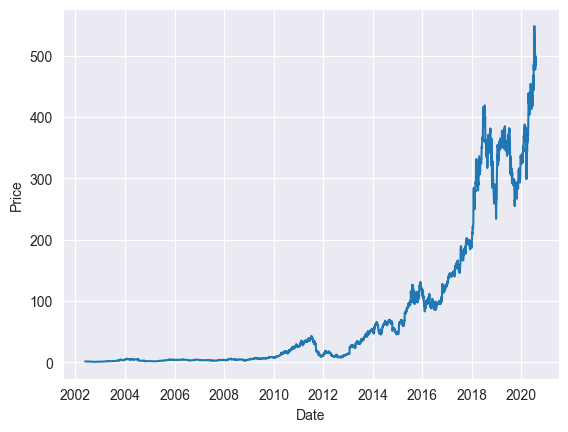

In [45]:
sns.lineplot(data=nflx_stock, x="Date", y="Close")
plt.ylabel("Price")
plt.show()

The price keeps increasing over time, showing the company is growing. Let's see how the volume changes.

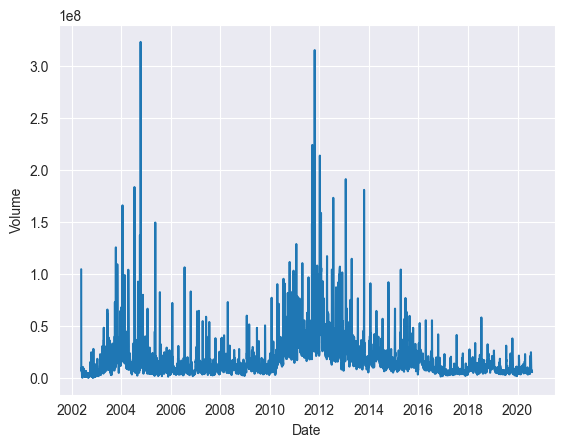

In [50]:
sns.lineplot(data=nflx_stock, x="Date", y="Volume")
plt.show()

The trends in volume aren't as clear compared to the price. We can see two significant spikes in trading volume in late 2004 and in 2012. Overall, later the trading volume is getting lower as time goes.

Let's see how the prices and volumes change depending on the day of the week.

In [59]:
nflx_stock.drop(columns=["Date"]).groupby("Weekday").mean()

,Open,High,Low,Close,Adj Close,Volume
Weekday,,,,,,
0,78.469131,79.860121,77.143506,78.626032,78.626032,1.687406e+07
1,77.886131,79.147035,76.615622,77.938861,77.938861,1.878554e+07
2,77.309623,78.587345,75.987330,77.364613,77.364613,1.775533e+07
3,78.468433,79.703384,77.152493,78.511928,78.511928,1.799244e+07
4,78.068629,79.183218,76.824263,77.970190,77.970190,1.654167e+07


Contrary to our initial assumption, the highest trading volume is in the middle of the workweek, the most on Tuesday. Prices were the highest on Monday though.

Let's visualize how throughout the time, the percentual difference between close and open was the biggest.

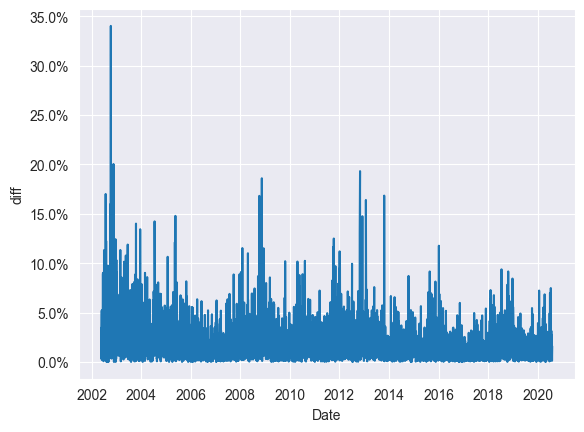

In [28]:
nflx_stock["diff"] = ((nflx_stock["Close"] - nflx_stock["Open"]) / nflx_stock["Open"]).abs()
sns.lineplot(data=nflx_stock, x=nflx_stock["Date"], y=nflx_stock["diff"])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.show()

We can see, the prices throughout the day have stabilized a bit since the beginning with fewer and smaller spikes since 2014.

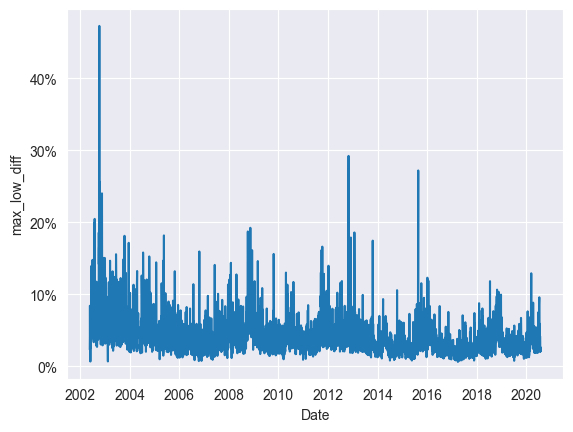

In [30]:
nflx_stock["max_low_diff"] = (nflx_stock["High"] - nflx_stock["Low"]) / nflx_stock["Open"]
sns.lineplot(data=nflx_stock, x=nflx_stock["Date"], y=nflx_stock["max_low_diff"])
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.show()

We cen see that percentual difference between daily maximum and minimum have been decreasing over time as well.

In [46]:
nflx_stock = nflx_stock.drop(columns=["diff", "max_low_diff"])

### Correlation

In [279]:
nflx_stock.corr()

,Date,Open,High,Low,Close,Volume
Date,1.000000,0.794332,0.794147,0.794708,0.794371,-0.028448
Open,0.794332,1.000000,0.999841,0.999830,0.999654,-0.193770
High,0.794147,0.999841,1.000000,0.999783,0.999840,-0.192107
Low,0.794708,0.999830,0.999783,1.000000,0.999834,-0.195478
Close,0.794371,0.999654,0.999840,0.999834,1.000000,-0.193671
Volume,-0.028448,-0.193770,-0.192107,-0.195478,-0.193671,1.000000


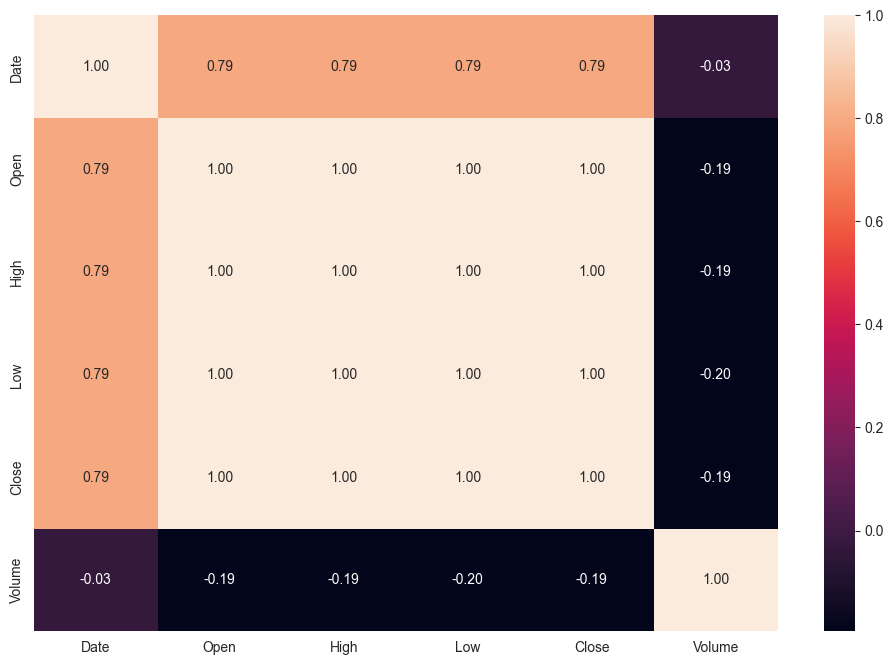

In [280]:
sns.heatmap(nflx_stock.corr(), annot=True, fmt=".2f")
plt.show()

We can see that all the prices are 1.00 correlated with each other, meaning we can likely use only itself to predict itself in the future.  

It also shows that weekday has no correlation with any other column, contradicting our initial assumption, showing the assumptions were coincidental. We can therefore remove the weekday column.

In [56]:
nflx_stock.drop(columns=["Weekday"], inplace=True)

### Stationarity and noise removal

	1. ADF :  2.1260797764442625
	2. P-Value :  0.998815959771424
	3. Num Of Lags :  32


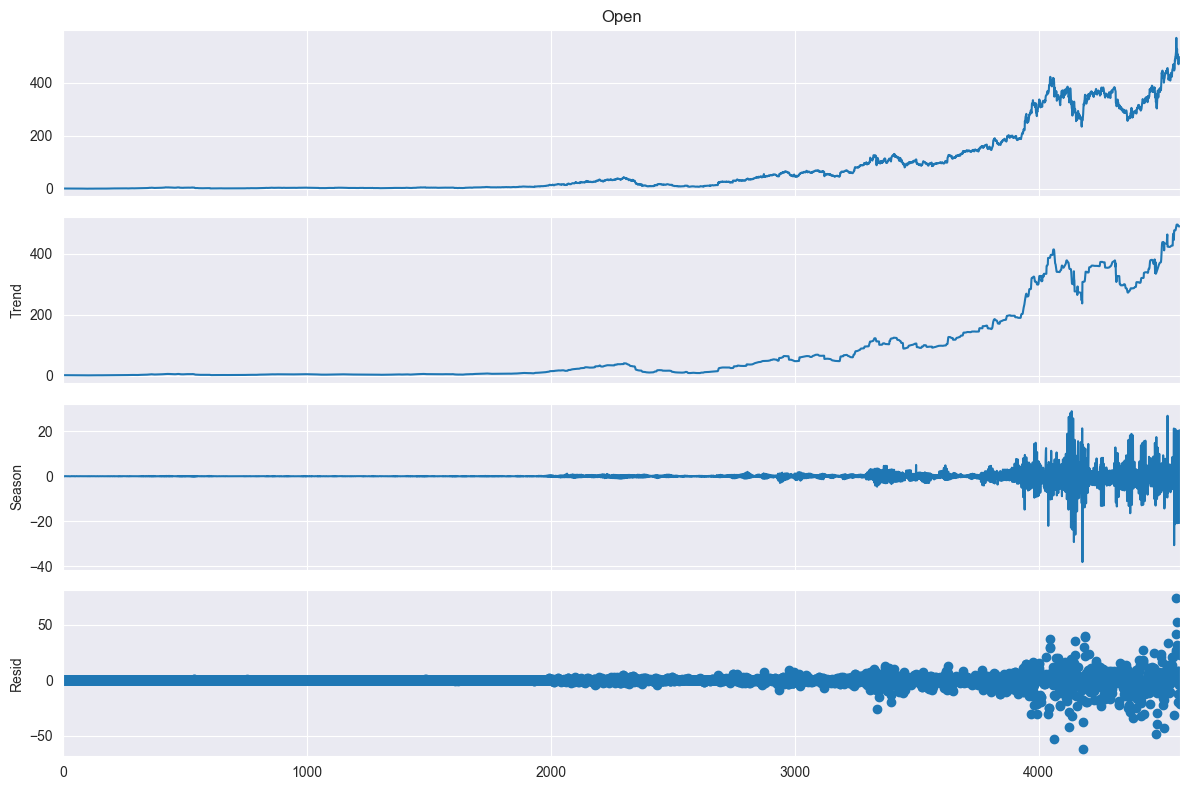

In [281]:
dftest = adfuller(nflx_stock["Open"], autolag = 'AIC')
print("\t1. ADF : ",dftest[0])
print("\t2. P-Value : ", dftest[1])
print("\t3. Num Of Lags : ", dftest[2])
          
result = STL(nflx_stock["Open"], period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (12,8)
result.plot()
plt.show()

In [ ]:
result = STL(nflx_stock["Volume"], period=6, robust = True).fit()
plt.rcParams["figure.figsize"] = (12,8)
result.plot()
plt.show()

We remove the noise from all the columns using STL decomposition.

In [5]:
for column in ["Open", "Close", "Low", "High", "Volume"]:
    result = STL(nflx_stock[column], period=6, robust = True).fit()
    nflx_stock[column] = result.trend + result.seasonal

### Scaling
We need to scale the data as volume is in a completely different range compared to all the other columns. For that, we will use MinMax scaling as it best suits our needs.

In [6]:
scaler = MinMaxScaler()
nflx_stock[nflx_stock.columns[1:]] = scaler.fit_transform(nflx_stock[nflx_stock.columns[1:]])

### Transformation
We will find whether we want to transform the data later using Grid Search or Bayes Search.

### Feature Selection
Feature selection will work differently in time series forecasting compared to classification. We will have to use lag/lookback to predict the future, not current state of other columns.  
We will have to adjust the lag and possibly other features and their lag.
As we use lag to depict how data changes over time, we can won't need to use Date column, as the information that price raises over time will already be contained within the lagged columns 

In [7]:
def add_lag(df: pd.DataFrame, column, lag=1):
    for i in range(1, lag+1):
        df[f"{column}_lag_{i}"] = df[column].shift(i)
    return df

We add a function that creates a new dataset based on chosen features and their lags. We don't need to worry about adding weekday in there, as there was no correlation between weekday and any other columns based on the heatmap.

In [8]:
def pick_lagged_features(df: pd.DataFrame, **column_lag_kw):
    df = df.copy()
    selected_columns = []
    for column, lag in column_lag_kw.items():
        if lag == 0:
            continue
        df = add_lag(df, column, lag)
        selected_columns.extend([f"{column}_lag_{i}" for i in range(1, lag + 1)])
    # bfill to deal with rows, where lag was not applicable. Dropna() would cause mismatch in lengths between that and the target column.
    df.bfill(inplace=True)
    return df[selected_columns] 

In [284]:
# example
pick_lagged_features(nflx_stock, Close=2, Volume=1, Low=0)

,Close_lag_1,Close_lag_2,Volume_lag_1
0,0.001463,0.001463,0.028104
1,0.001463,0.001463,0.028104
2,0.001454,0.001463,0.022223
3,0.001414,0.001454,0.046534
4,0.001325,0.001414,0.052610
...,...,...,...
4576,0.950696,0.947405,0.070912
4577,0.942957,0.950696,0.074807
4578,0.929421,0.942957,0.067121
4579,0.938718,0.929421,0.058966


# Finding the best model

Split the data into train and test set. Splitting them randomly makes no sense, as the data is sequential. We split the data at the beginning of 2019 to have roughly 10% of the data as test data.

In [13]:
train = nflx_stock[nflx_stock["Date"] < "2019-01-01"]
test = nflx_stock[nflx_stock["Date"] >= "2019-01-01"]
train.shape[0], test.shape[0]

(4181, 400)

#### We don't define X and y yet, as we are forecasting all values, therefore we will use all columns as y at some point.

## Machine Learning
First, let's try to use the models from sklearn, that are the simplest to use, and see how they perform.

We create a feature selector that we can use in the Bayes Search.


!Note!: We ran the following code in google colab, while the rest was run locally, so we have written the best 

In [9]:
class FeatureLagTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, Open_lag=0, Close_lag=0, Low_lag=0, High_lag=0, Volume_lag=0):
        self.Open_lag = Open_lag
        self.Close_lag = Close_lag
        self.Low_lag = Low_lag
        self.High_lag = High_lag
        self.Volume_lag = Volume_lag
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pick_lagged_features(X, **{
            "Open": self.Open_lag,
            "Close": self.Close_lag,
            "Low": self.Low_lag,
            "High": self.High_lag,
            "Volume": self.Volume_lag
        })

In [10]:
def get_best_pipeline(data, predicted_column, estimator, n_iter=100, **estimator_params):
    pipeline = Pipeline([
        ("feature_selector", FeatureLagTransformer()),
        ("model", estimator)
    ])
    # allow greater depth only for the predicted column
    search_space = {
        "feature_selector__Open_lag": Integer(0, 3) if predicted_column != "Open" else Integer(1, 10),
        "feature_selector__Close_lag": Integer(0, 3) if predicted_column != "Close" else Integer(1, 10),
        "feature_selector__Low_lag": Integer(0, 3) if predicted_column != "Low" else Integer(1, 10),
        "feature_selector__High_lag": Integer(0, 3) if predicted_column != "High" else Integer(1, 10),
        # as volume isn't correlated well with the other columns, we have to use a higher lag for predicting itself, but no need for the other columns
        "feature_selector__Volume_lag": Integer(0, 3) if predicted_column != "Volume" else Integer(1, 100),
    }
    # add kwargs for the estimator to the search space
    search_space.update({f"model__{key}": value for key, value in estimator_params.items()})
    optimizer = BayesSearchCV(
        estimator=pipeline, 
        search_spaces=search_space, 
        n_iter=n_iter, 
        cv=5,
        scoring=make_scorer(mean_squared_error, greater_is_better=False),
        n_jobs=-1,
    )
    optimizer.fit(data, data[predicted_column])
    print(optimizer.best_params_)
    return optimizer.best_estimator_

### Linear Regression
Let's begin with the simplest model as the benchmark, Linear Regression.

In [13]:
lin_reg_pipelines = {
    "Open": get_best_pipeline(train, "Open", LinearRegression()),
    "Close": get_best_pipeline(train, "Close", LinearRegression()),
    "Low": get_best_pipeline(train, "Low", LinearRegression()),
    "High": get_best_pipeline(train, "High", LinearRegression()),
    "Volume": get_best_pipeline(train, "Volume", LinearRegression())
}

OrderedDict({'feature_selector__Close_lag': 3, 'feature_selector__High_lag': 1, 'feature_selector__Low_lag': 1, 'feature_selector__Open_lag': 7, 'feature_selector__Volume_lag': 0})


C:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 3, 2, 0, 0] before, using random point [7, 0, 3, 0, 0]
  warnings.warn(


OrderedDict({'feature_selector__Close_lag': 1, 'feature_selector__High_lag': 3, 'feature_selector__Low_lag': 2, 'feature_selector__Open_lag': 0, 'feature_selector__Volume_lag': 0})


C:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 2, 1, 1, 2] before, using random point [3, 1, 4, 2, 2]
  warnings.warn(
C:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [2, 3, 2, 0, 3] before, using random point [1, 0, 3, 2, 3]
  warnings.warn(
C:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 3, 1, 0, 0] before, using random point [1, 2, 2, 2, 0]
  warnings.warn(
C:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [0, 3, 1, 3, 0] before, using random point [1, 1, 7, 3, 3]
  warnings.warn(


OrderedDict({'feature_selector__Close_lag': 1, 'feature_selector__High_lag': 0, 'feature_selector__Low_lag': 2, 'feature_selector__Open_lag': 0, 'feature_selector__Volume_lag': 1})
OrderedDict({'feature_selector__Close_lag': 2, 'feature_selector__High_lag': 1, 'feature_selector__Low_lag': 1, 'feature_selector__Open_lag': 0, 'feature_selector__Volume_lag': 0})
OrderedDict({'feature_selector__Close_lag': 0, 'feature_selector__High_lag': 0, 'feature_selector__Low_lag': 0, 'feature_selector__Open_lag': 0, 'feature_selector__Volume_lag': 44})


In [14]:
# So we can reuse the code without running the optimization again
lin_reg_pipelines = {}
for column in ["Open", "Close", "Low", "High", "Volume"]:
    lin_reg_pipelines[column] = Pipeline([
    ("feature_selector", FeatureLagTransformer()),
    ("model", LinearRegression())
    ])
lin_reg_pipelines["Open"].set_params(**{'feature_selector__Close_lag': 3, 'feature_selector__High_lag': 1, 'feature_selector__Low_lag': 1, 'feature_selector__Open_lag': 7, 'feature_selector__Volume_lag': 0})
lin_reg_pipelines["Close"].set_params(**{'feature_selector__Close_lag': 1, 'feature_selector__High_lag': 3, 'feature_selector__Low_lag': 2, 'feature_selector__Open_lag': 0, 'feature_selector__Volume_lag': 0})
lin_reg_pipelines["Low"].set_params(**{'feature_selector__Close_lag': 1, 'feature_selector__High_lag': 0, 'feature_selector__Low_lag': 2, 'feature_selector__Open_lag': 0, 'feature_selector__Volume_lag': 1})
lin_reg_pipelines["High"].set_params(**{'feature_selector__Close_lag': 2, 'feature_selector__High_lag': 1, 'feature_selector__Low_lag': 1, 'feature_selector__Open_lag': 0, 'feature_selector__Volume_lag': 0})
lin_reg_pipelines["Volume"].set_params(**{'feature_selector__Close_lag': 0, 'feature_selector__High_lag': 0, 'feature_selector__Low_lag': 0, 'feature_selector__Open_lag': 0, 'feature_selector__Volume_lag': 44})
for key, pipeline in lin_reg_pipelines.items():
    pipeline.fit(train, train[key])

In [15]:
combined = pd.DataFrame()
for key in ["Open", "Close", "Low", "High", "Volume"]:
    combined[f"{key}"] = lin_reg_pipelines[key].predict(test)

In [16]:
lin_reg_results: dict[str, dict] = {}
for key, pipeline in lin_reg_pipelines.items():
    predicted_data = pipeline.predict(test)
    lin_reg_results[key] = {
        "mse": mean_squared_error(test[key], predicted_data),
        "r2": r2_score(test[key], predicted_data),
        "data": predicted_data
    }
lin_reg_results["Combined"] = {
    "mse": mean_squared_error(test.drop(columns=["Date"]), combined),
    "r2": r2_score(test.drop(columns=["Date"]), combined),
    "data": combined
}
for key, item in lin_reg_results.items():
    print(f"{key}: MSE: {item['mse']}, R2: {item['r2']}")

Open: MSE: 0.0002569519425931539, R2: 0.9773023721456402
Close: MSE: 0.0002436710777142558, R2: 0.9793538986240929
Low: MSE: 0.00023333334552178128, R2: 0.9809604336635609
High: MSE: 0.0002476997959709231, R2: 0.9785543156293707
Volume: MSE: 4.684035248214802e-05, R2: 0.9330197372909435
Combined: MSE: 0.000496601451556471, R2: 0.944932124493332


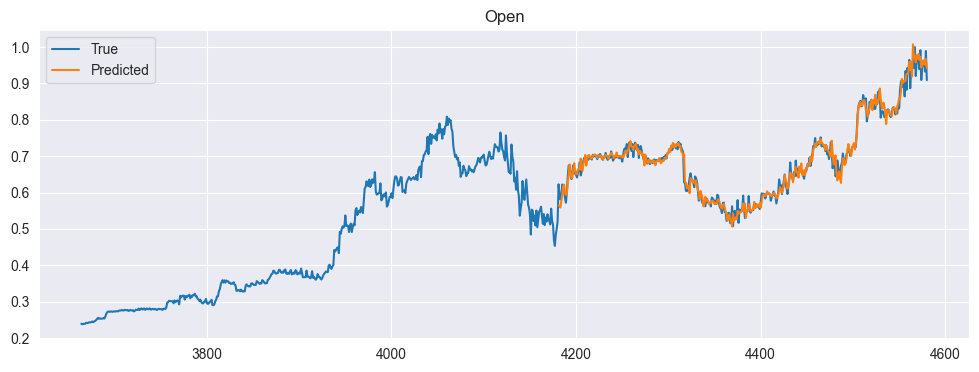

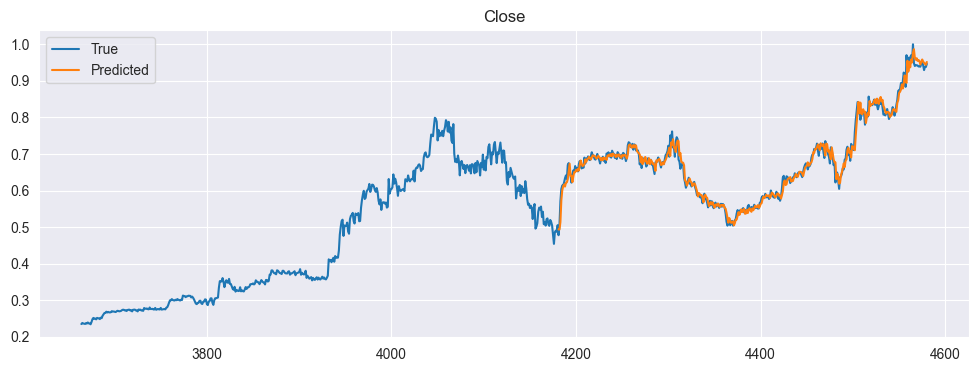

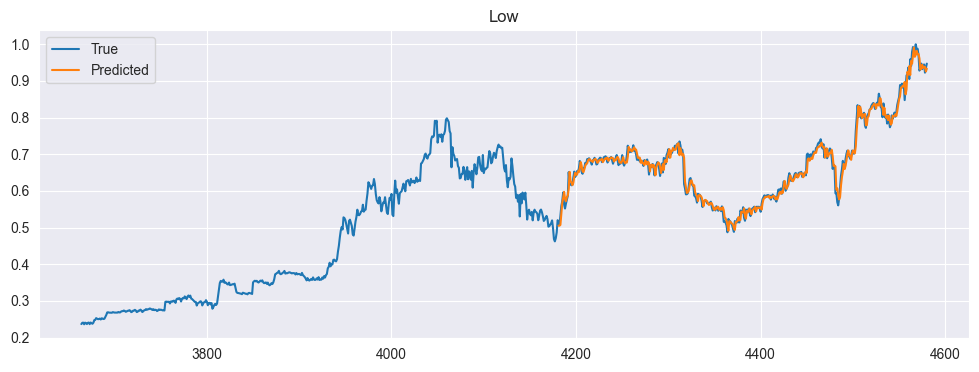

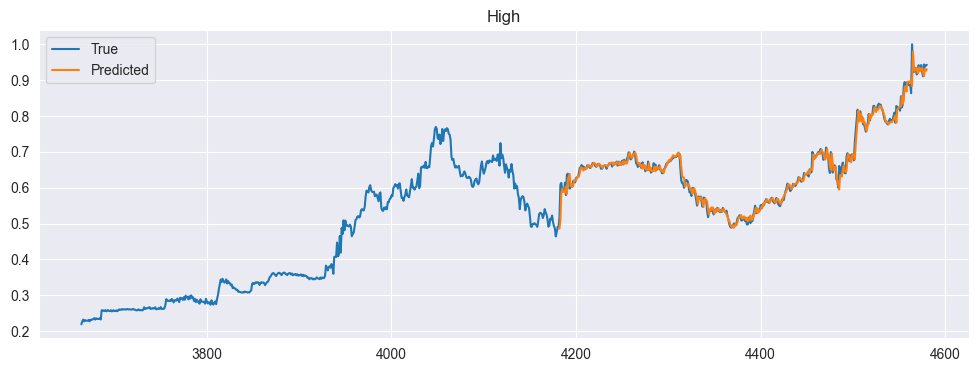

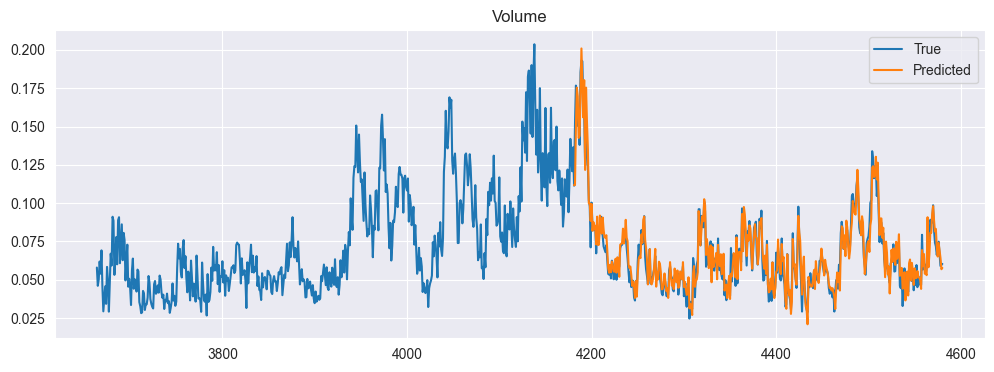

In [26]:
start_index = int(len(nflx_stock) * 4 // 5)
total_length = nflx_stock.shape[0]
pred_padding_length = total_length - len(lin_reg_results["Open"]["data"])
for col in ["Open", "Close", "Low", "High", "Volume"]:
    y_pred = lin_reg_results[col]["data"]
    y_true = nflx_stock[col].iloc[start_index:]
    plt.figure(figsize=(12, 4))
    plt.plot(y_true, label="True")
    plt.plot(range(pred_padding_length, total_length), y_pred, label="Predicted")
    plt.title(col)
    plt.legend()
    plt.show()

### Random Forest Regressor

In [216]:
rf_hyperparams = {
    "n_estimators": Integer(10, 200),
    "max_depth": Integer(1, 10),
    "criterion": Categorical(["squared_error", "absolute_error", "friedman_mse", "poisson"]),
    "max_features": Categorical(["sqrt", "log2"]),
}
rf_pipelines = {}
for column in ["Open", "Close", "Low", "High", "Volume"]:
    rf_pipelines[column] = get_best_pipeline(train, column, RandomForestRegressor(), **rf_hyperparams)

OrderedDict({'feature_selector__Close_lag': 1, 'feature_selector__High_lag': 0, 'feature_selector__Low_lag': 1, 'feature_selector__Open_lag': 1, 'feature_selector__Volume_lag': 0, 'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__max_features': 'sqrt', 'model__n_estimators': 86})
OrderedDict({'feature_selector__Close_lag': 1, 'feature_selector__High_lag': 1, 'feature_selector__Low_lag': 0, 'feature_selector__Open_lag': 1, 'feature_selector__Volume_lag': 0, 'model__criterion': 'friedman_mse', 'model__max_depth': 6, 'model__max_features': 'sqrt', 'model__n_estimators': 200})
OrderedDict({'feature_selector__Close_lag': 0, 'feature_selector__High_lag': 3, 'feature_selector__Low_lag': 1, 'feature_selector__Open_lag': 3, 'feature_selector__Volume_lag': 0, 'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__max_features': 'log2', 'model__n_estimators': 172})
OrderedDict({'feature_selector__Close_lag': 0, 'feature_selector__High_lag': 2, 'feature_selector__

In [93]:
# for reusability, when we want to rerun the code without rerunning hyperparameter optimization
rf_pipelines = {}
for column in ["Open", "Close", "Low", "High", "Volume"]:
    rf_pipelines[column] = Pipeline([
    ("feature_selector", FeatureLagTransformer()),
    ("model", RandomForestRegressor())
])

rf_pipelines["Open"].set_params(**{'feature_selector__Close_lag': 1, 'feature_selector__High_lag': 0, 'feature_selector__Low_lag': 1, 'feature_selector__Open_lag': 1, 'feature_selector__Volume_lag': 0, 'model__criterion': 'absolute_error', 'model__max_depth': 8, 'model__max_features': 'sqrt', 'model__n_estimators': 86})
rf_pipelines["Close"].set_params(**{'feature_selector__Close_lag': 1, 'feature_selector__High_lag': 1, 'feature_selector__Low_lag': 0, 'feature_selector__Open_lag': 1, 'feature_selector__Volume_lag': 0, 'model__criterion': 'friedman_mse', 'model__max_depth': 6, 'model__max_features': 'sqrt', 'model__n_estimators': 200})
rf_pipelines["Low"].set_params(**{'feature_selector__Close_lag': 0, 'feature_selector__High_lag': 3, 'feature_selector__Low_lag': 1, 'feature_selector__Open_lag': 3, 'feature_selector__Volume_lag': 0, 'model__criterion': 'absolute_error', 'model__max_depth': 10, 'model__max_features': 'log2', 'model__n_estimators': 172})
rf_pipelines["High"].set_params(**{'feature_selector__Close_lag': 0, 'feature_selector__High_lag': 2, 'feature_selector__Low_lag': 1, 'feature_selector__Open_lag': 1, 'feature_selector__Volume_lag': 1, 'model__criterion': 'squared_error', 'model__max_depth': 8, 'model__max_features': 'sqrt', 'model__n_estimators': 106})
rf_pipelines["Volume"].set_params(**{'feature_selector__Close_lag': 1, 'feature_selector__High_lag': 1, 'feature_selector__Low_lag': 2, 'feature_selector__Open_lag': 3, 'feature_selector__Volume_lag': 13, 'model__criterion': 'poisson', 'model__max_depth': 6, 'model__max_features': 'sqrt', 'model__n_estimators': 196})

for key, pipeline in rf_pipelines.items():
    pipeline.fit(train, train[key])

In [94]:
rf_results: dict[str, dict] = {}
for key, pipeline in rf_pipelines.items():
    predicted_data = pipeline.predict(test)
    rf_results[key] = {
        "mse": mean_squared_error(test[key], predicted_data),
        "r2": r2_score(test[key], predicted_data),
        "data": predicted_data
    }
    
for key, item in rf_results.items():
    print(f"{key}: MSE: {item['mse']}, R2: {item['r2']}")

Open: MSE: 0.002226513890766074, R2: 0.8033228190643092
Close: MSE: 0.0026620294104663022, R2: 0.7744478762531537
Low: MSE: 0.002967587075903922, R2: 0.7578504226882657
High: MSE: 0.002616333185851713, R2: 0.7734796046470489
Volume: MSE: 0.000181465669427658, R2: 0.7405096766602736


Surprisingly, the results for Random Forest Regressor are considerably worse than for Linear Regression.

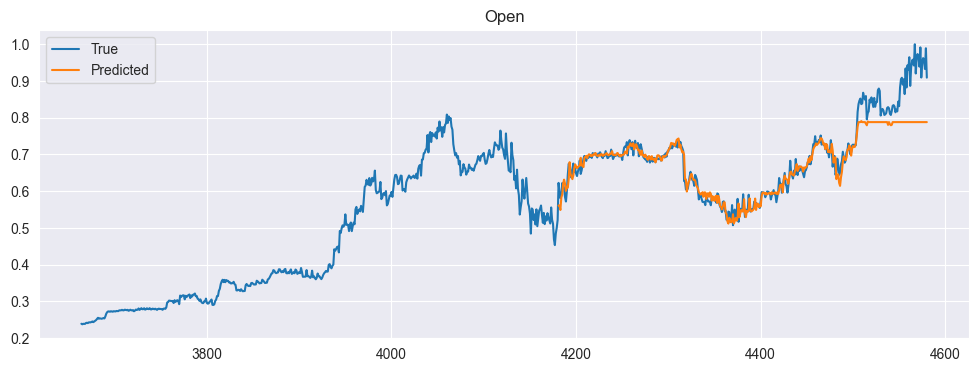

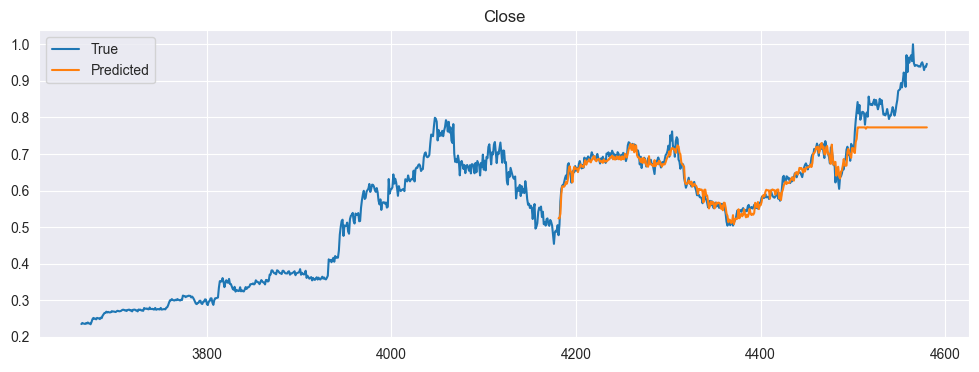

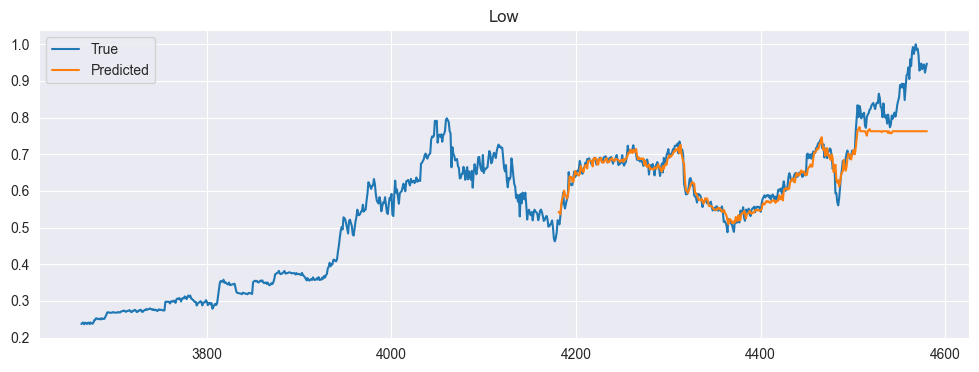

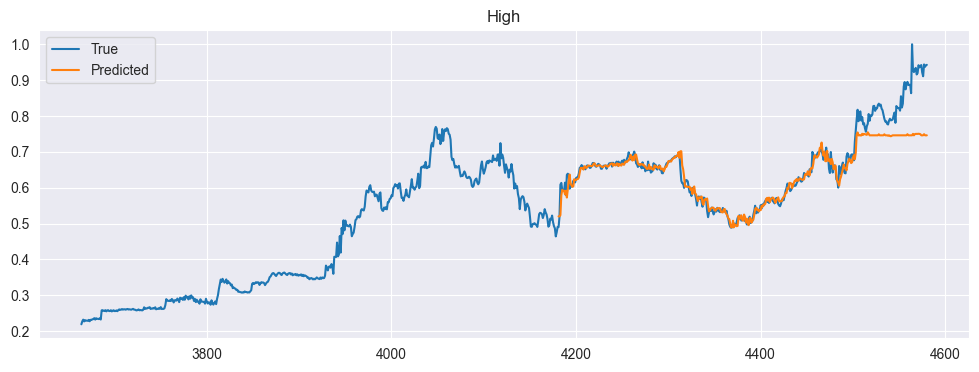

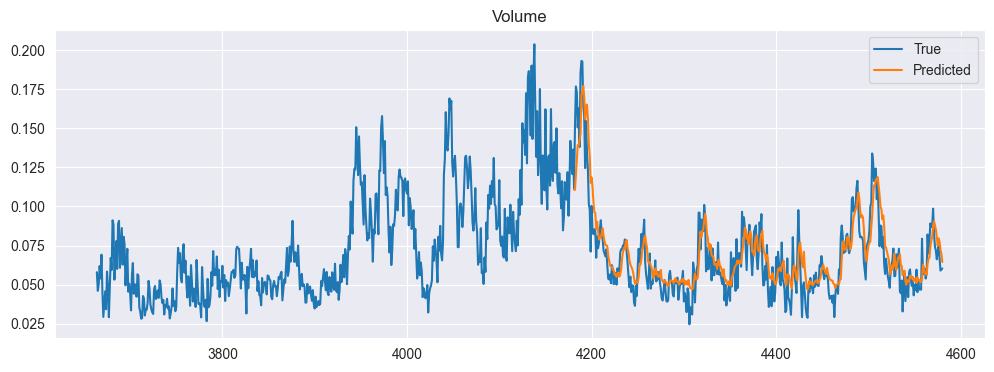

In [95]:
start_index = int(len(nflx_stock) * 4 // 5)
total_length = nflx_stock.shape[0]
pred_padding_length = total_length - len(rf_results["Open"]["data"])
for col in ["Open", "Close", "Low", "High", "Volume"]:
    y_pred = rf_results[col]["data"]
    y_true = nflx_stock[col].iloc[start_index:]
    plt.figure(figsize=(12, 4))
    plt.plot(y_true, label="True")
    plt.plot(range(pred_padding_length, total_length), y_pred, label="Predicted")
    plt.title(col)
    plt.legend()
    plt.show()

The problem seems to be that Random Forrest Regressor doesn't predict values outside of the observed range, meaning if the trend grows, the output will be capped at the highest observed value. Even if that weren't the case, as in the Volume column, the Linear Regression still outperforms Random Forrest Regressor.

## Deep Learning

In [19]:
dl_train = train.drop(columns=["Date"])
dl_test = test.drop(columns=["Date"])
look_back = 10
train_data_gen = TimeseriesGenerator(dl_train.values, 
                                     dl_train.values,
                                     length=look_back, 
                                     sampling_rate=1,
                                     stride=1,
                                     batch_size=1
                                    )

test_data_gen = TimeseriesGenerator(dl_test.values, 
                                    dl_test.values,
                                    length=look_back, 
                                    sampling_rate=1,
                                    stride=1,
                                    batch_size=1
                                   )

#### We will use different layers in RNN to see which one performs the best.

### LSTM

In [40]:
x = Input(shape=(look_back, 5)) # 5 columns
h = LSTM(units=15)(x)           # (x) because h is the output layer of x
y = Dense(units=5, activation='sigmoid')(h)
model_lstm = Model(inputs=x, outputs=y)
print(model_lstm.summary())

opt = Adam(learning_rate=0.001)
model_lstm.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae'])

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 10, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 15)             │         1,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │            80 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,340 (5.23 KB)

 Trainable params: 1,340 (5.23 KB)

 Non-trainable params: 0 (0.00 B)

None


In [41]:
model_lstm.fit(train_data_gen, epochs=20)

Epoch 1/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0192 - mae: 0.0814 - mse: 0.0192
Epoch 2/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 9.4359e-04 - mae: 0.0186 - mse: 9.4359e-04
Epoch 3/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 6.3872e-04 - mae: 0.0134 - mse: 6.3872e-04
Epoch 4/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 5.2185e-04 - mae: 0.0117 - mse: 5.2185e-04
Epoch 5/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 5.2287e-04 - mae: 0.0111 - mse: 5.2287e-04
Epoch 6/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 5.1640e-04 - mae: 0.0109 - mse: 5.1640e-04
Epoch 7/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 5.5140e-04 - mae: 0.0104 - mse: 5.5140e-04
Epoch 8/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 5.2144e-04 - mae: 0.0103 - mse: 5.2144e-04
Epoch 9/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 4.6886e-04 - mae: 0.0097 - mse: 4.6886e-04
Epoch 10/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/ste

In [42]:
model_lstm.evaluate(test_data_gen)

390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.6315e-04 - mae: 0.0119 - mse: 2.6315e-04


[0.0007102230447344482, 0.0007102230447344482, 0.017571385949850082]

In [43]:
model_lstm.evaluate(train_data_gen)

4171/4171 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 3.1325e-04 - mae: 0.0065 - mse: 3.1325e-04


[0.0003999313048552722, 0.0003999313048552722, 0.008045300841331482]

#### Now we plot our predictions based on example from seminar

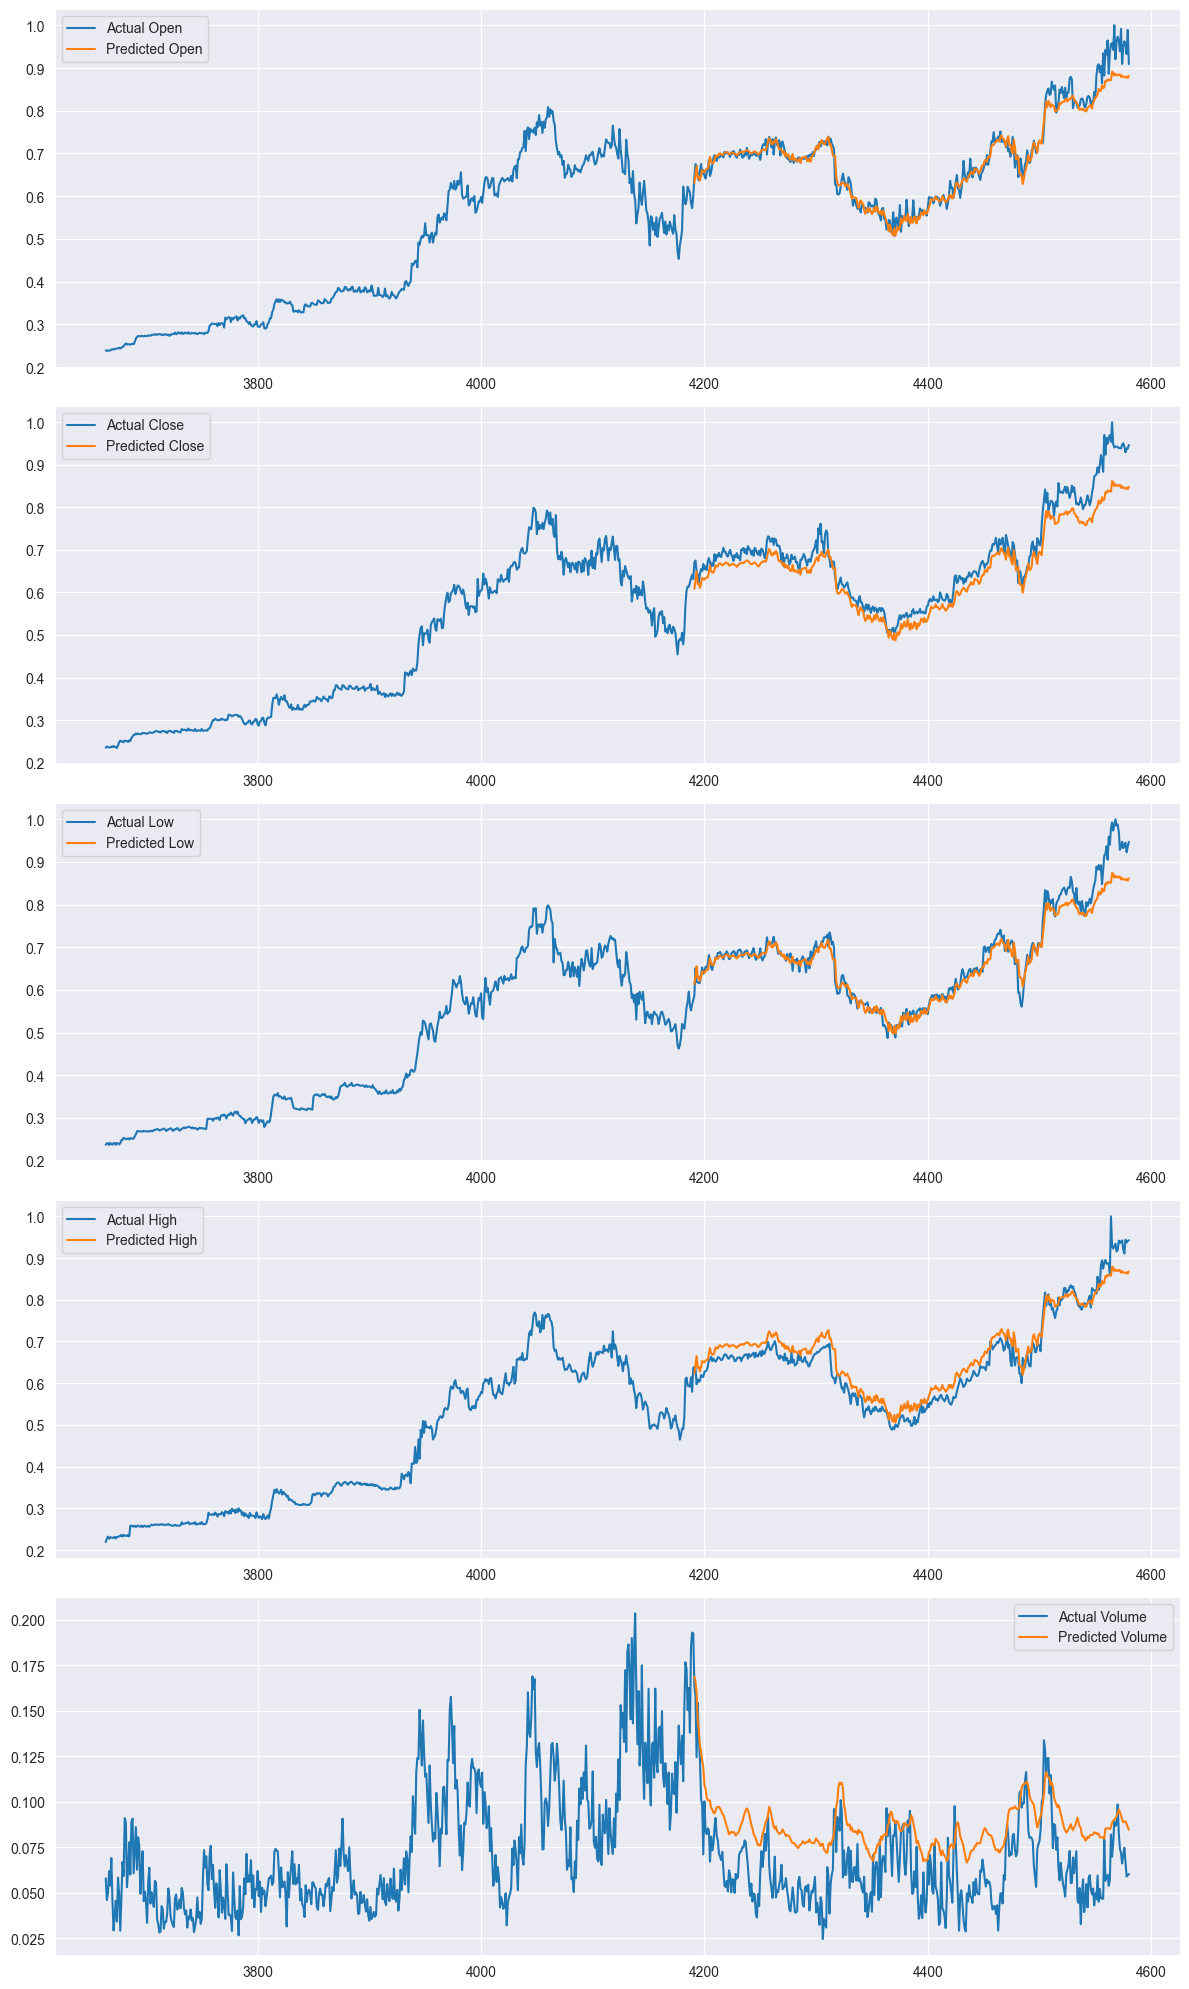

In [355]:
y_pred = model_lstm.predict(test_data_gen)
start_index = int(len(nflx_stock) * 4 // 5)
total_length = nflx_stock.shape[0]
pred_padding_length = total_length - len(y_pred)

feature_names = ["Open", "Close", "Low", "High", "Volume"]
for i in range(len(feature_names)):
    y_true = nflx_stock[col].iloc[start_index:]
    plt.figure(figsize=(12, 4))
    plt.plot(y_true, label="True")
    plt.plot(range(pred_padding_length, total_length), y_pred[:, i], label="Predicted")
    plt.title(col)
    plt.legend()
    plt.show()

### GRU

In [20]:
x = Input(shape=(look_back, 5)) 
h = GRU(units=15)(x)
y = Dense(units=5, activation='sigmoid')(h)
model_gru = Model(inputs=x, outputs=y)
print(model_gru.summary())

opt = Adam(learning_rate=0.001)
model_gru.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae'])

model_gru.fit(train_data_gen, epochs=20)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 10, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 15)             │           990 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            80 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,070 (4.18 KB)

 Trainable params: 1,070 (4.18 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20


C:\Users\marti\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4171/4171 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0210 - mae: 0.0845 - mse: 0.0210
Epoch 2/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 7.7371e-04 - mae: 0.0165 - mse: 7.7371e-04
Epoch 3/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 5.2914e-04 - mae: 0.0114 - mse: 5.2914e-04
Epoch 4/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 5.2403e-04 - mae: 0.0107 - mse: 5.2403e-04
Epoch 5/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 5.1355e-04 - mae: 0.0103 - mse: 5.1355e-04
Epoch 6/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 4.5784e-04 - mae: 0.0096 - mse: 4.5784e-04
Epoch 7/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 5.3215e-04 - mae: 0.0099 - mse: 5.3215e-04
Epoch 8/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 4.5559e-04 - mae: 0.0093 - mse: 4.5559e-04
Epoch 9/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 4.7294e-04 - mae: 0.0093 - mse: 4.7294e-04
Epoch 10/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 5

[0.0004507005214691162, 0.0004507005214691162, 0.009292815811932087]

In [22]:
model_gru.evaluate(test_data_gen)

390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8013e-04 - mae: 0.0157 - mse: 3.8013e-04


[0.0006902701570652425, 0.0006902701570652425, 0.019361423328518867]

In [23]:
model_gru.evaluate(train_data_gen)

4171/4171 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 3.3325e-04 - mae: 0.0081 - mse: 3.3325e-04


[0.0004507005214691162, 0.0004507005214691162, 0.009292815811932087]

390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


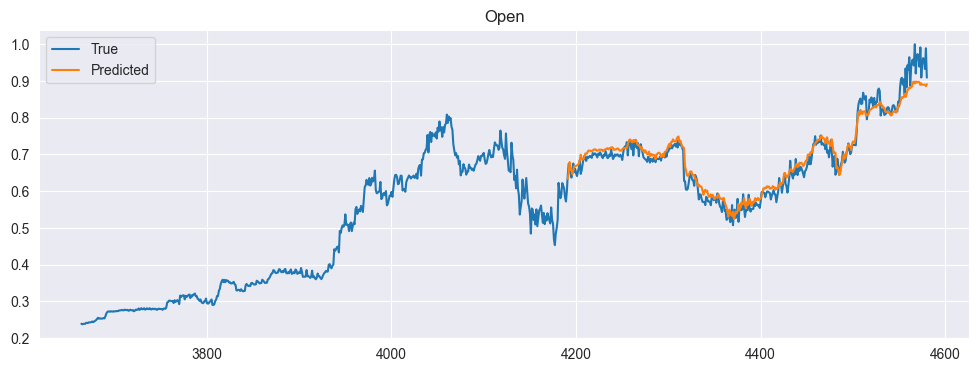

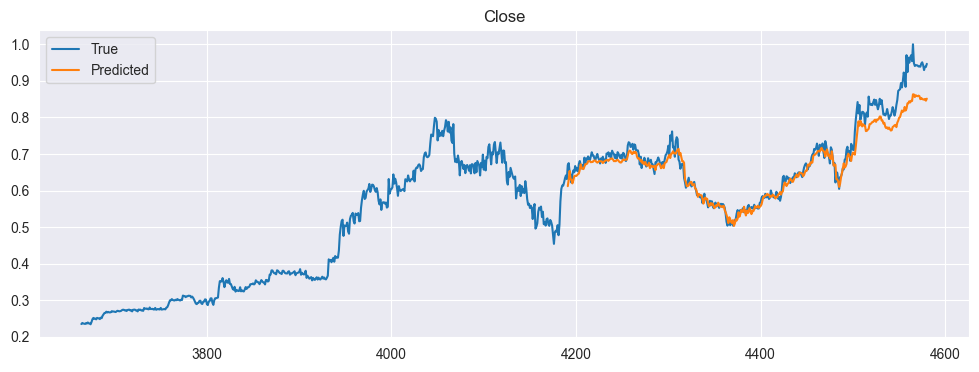

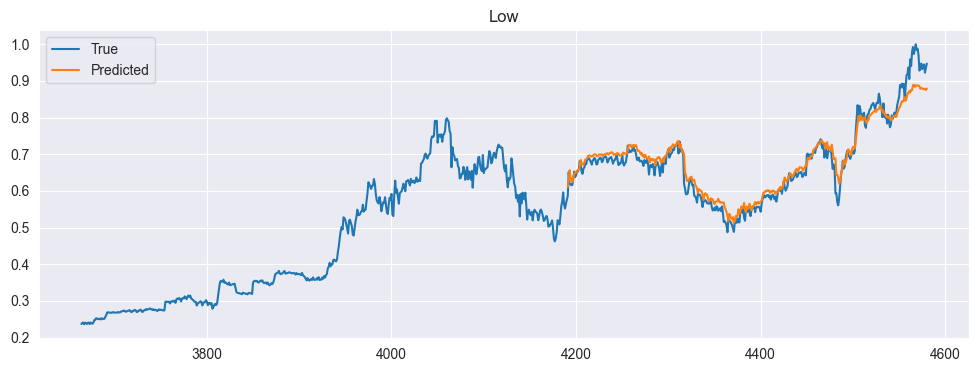

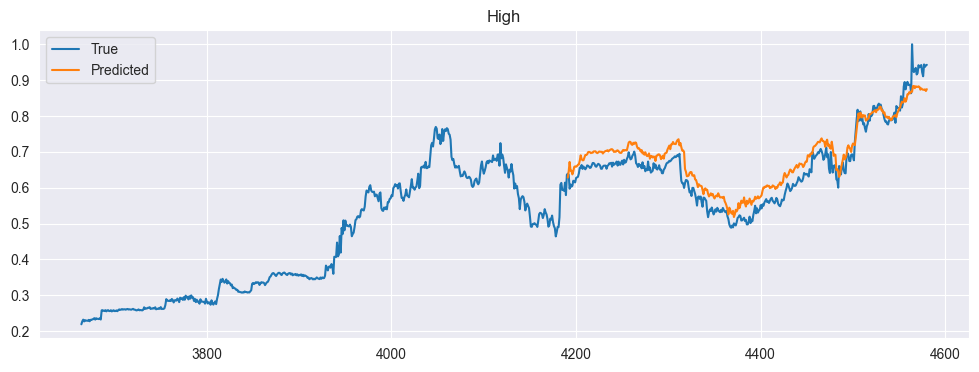

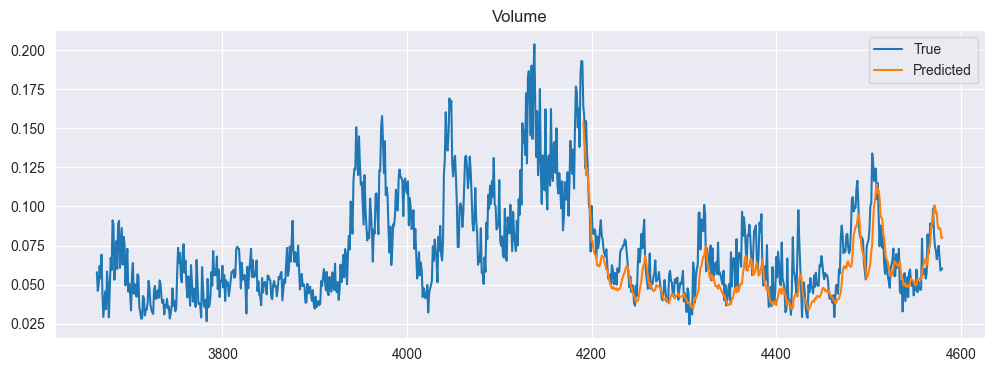

In [27]:
y_pred = model_gru.predict(test_data_gen)  
start_index = int(len(nflx_stock) * 4 // 5)
total_length = nflx_stock.shape[0]
pred_padding_length = total_length - len(y_pred)
columns = ["Open", "Close", "Low", "High", "Volume"]
for i in range(len(columns)):
    y_true = nflx_stock[columns[i]].iloc[start_index:]
    plt.figure(figsize=(12, 4))
    plt.plot(y_true, label="True")
    plt.plot(range(pred_padding_length, total_length), y_pred[:, i], label="Predicted")
    plt.title(columns[i])
    plt.legend()
    plt.show()

We can see that the results don't differ much from LSTM

### Simple RNN
Let's see how the simplest RNN performs.

In [84]:
x = Input(shape=(look_back, 5))
h = SimpleRNN(units=15)(x)
y = Dense(units=5, activation='sigmoid')(h)
model_rnn = Model(inputs=x, outputs=y)
print(model_rnn.summary())

opt = Adam(learning_rate=0.001)
model_rnn.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae'])
model_rnn.fit(train_data_gen, epochs=20)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 10, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 15)             │           315 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │            80 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 395 (1.54 KB)

 Trainable params: 395 (1.54 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0229 - mae: 0.0963 - mse: 0.0229
Epoch 2/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0012 - mae: 0.0193 - mse: 0.0012
Epoch 3/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 9.5029e-04 - mae: 0.0166 - mse: 9.5029e-04
Epoch 4/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 7.7388e-04 - mae: 0.0153 - mse: 7.7388e-04
Epoch 5/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 5.6957e-04 - mae: 0.0135 - mse: 5.6957e-04
Epoch 6/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 4.5480e-04 - mae: 0.0120 - mse: 4.5480e-04
Epoch 7/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 3.7880e-04 - mae: 0.0110 - mse: 3.7880e-04
Epoch 8/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 3.8350e-04 - mae: 0.0108 - mse: 3.8350e-04
Epoch 9/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 3.4489e-04 - mae: 0.0101 - mse: 3.4489e-04
Epoch 10/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - lo

In [83]:
model_rnn.evaluate(test_data_gen)

390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1742 - mae: 0.2693 - mse: 0.1742


[0.19270937144756317, 0.19270937144756317, 0.28183770179748535]

In [30]:
model_rnn.evaluate(train_data_gen)

4171/4171 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 1.5498e-04 - mae: 0.0067 - mse: 1.5498e-04


[0.0002109332854161039, 0.0002109332854161039, 0.007878061383962631]

390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


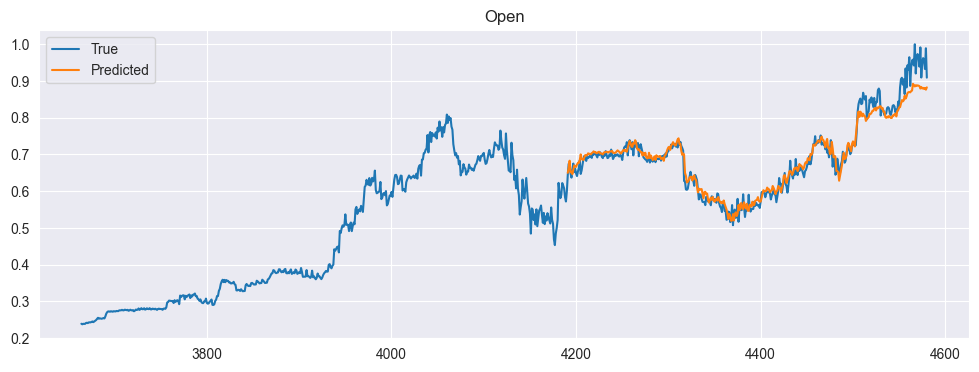

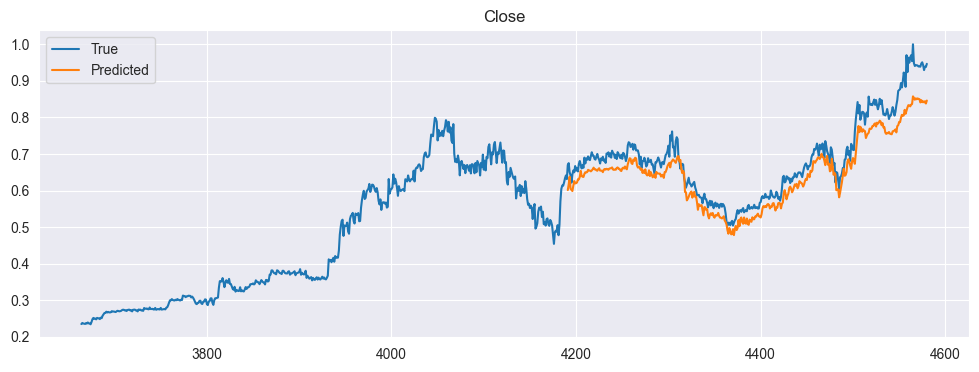

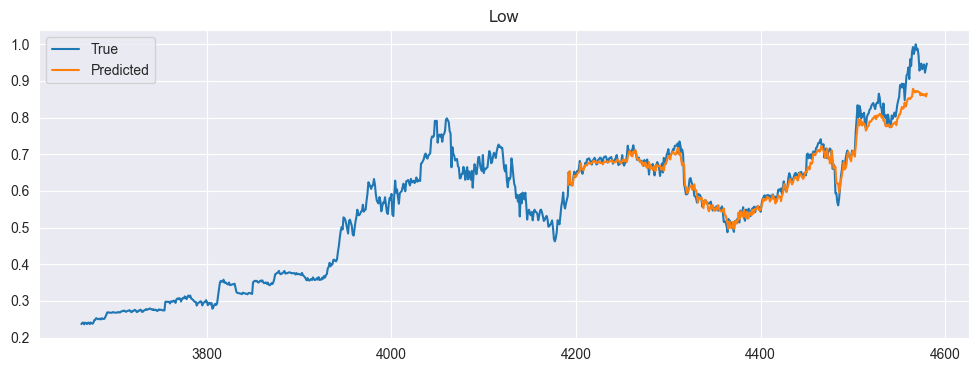

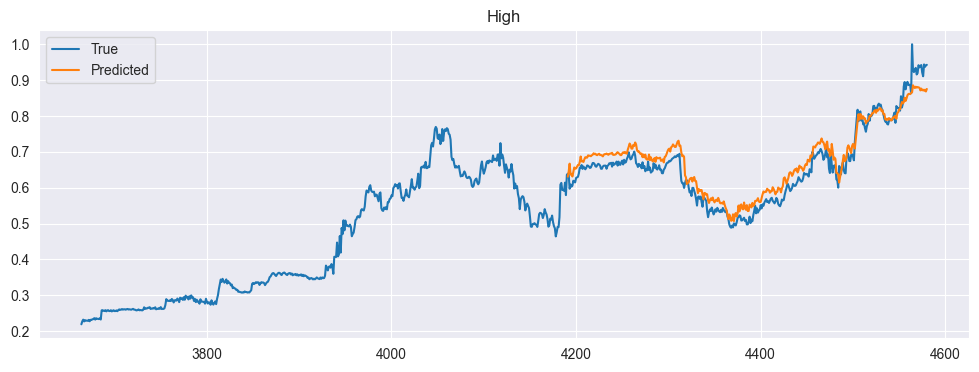

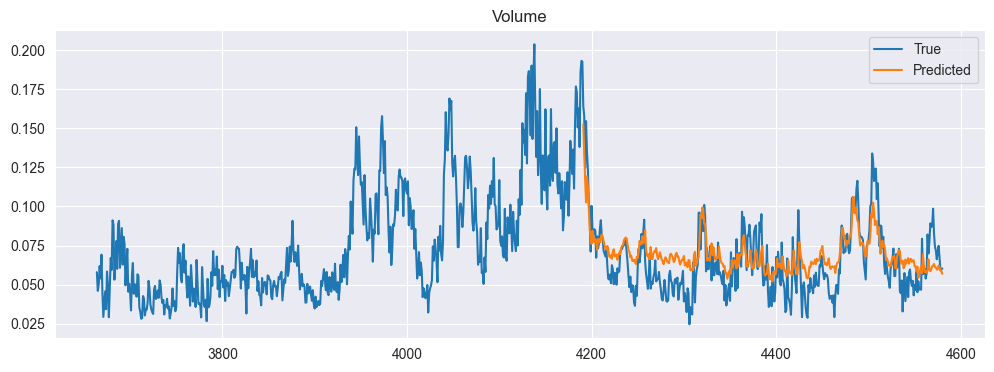

In [32]:
y_pred = model_rnn.predict(test_data_gen)  
start_index = int(len(nflx_stock) * 4 // 5)
total_length = nflx_stock.shape[0]
pred_padding_length = total_length - len(y_pred)
columns = ["Open", "Close", "Low", "High", "Volume"]
for i in range(len(columns)):
    y_true = nflx_stock[columns[i]].iloc[start_index:]
    plt.figure(figsize=(12, 4))
    plt.plot(y_true, label="True")
    plt.plot(range(pred_padding_length, total_length), y_pred[:, i], label="Predicted")
    plt.title(columns[i])
    plt.legend()
    plt.show()

### Stacked RNN

In [36]:
x = Input(shape=(look_back, 5))
h = LSTM(units=15, return_sequences=True)(x)
h = LSTM(units=15)(h)
y = Dense(units=5, activation='sigmoid')(h)
model_stacked_rnn = Model(inputs=x, outputs=y)
print(model_stacked_rnn.summary())

opt = Adam(learning_rate=0.001)
model_stacked_rnn.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae'])
model_stacked_rnn.fit(train_data_gen, epochs=20)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 10, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 10, 15)         │         1,260 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 15)             │         1,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │            80 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,200 (12.50 KB)

 Trainable params: 3,200 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - loss: 0.0157 - mae: 0.0719 - mse: 0.0157
Epoch 2/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 9.4232e-04 - mae: 0.0163 - mse: 9.4232e-04
Epoch 3/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 7.7194e-04 - mae: 0.0143 - mse: 7.7194e-04
Epoch 4/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 5.9232e-04 - mae: 0.0124 - mse: 5.9232e-04
Epoch 5/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 5.6236e-04 - mae: 0.0120 - mse: 5.6236e-04
Epoch 6/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 5.3564e-04 - mae: 0.0115 - mse: 5.3564e-04
Epoch 7/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 5.5855e-04 - mae: 0.0113 - mse: 5.5855e-04
Epoch 8/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 5.2716e-04 - mae: 0.0107 - mse: 5.2716e-04
Epoch 9/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - loss: 5.2304e-04 - mae: 0.0105 - mse: 5.2304e-04
Epoch 10/20
4171/4171 ━━━━━━━━━━━━━━━━━━━━ 17s 4m

In [37]:
model_stacked_rnn.evaluate(test_data_gen)

390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.2076e-04 - mae: 0.0137 - mse: 3.2076e-04


[0.0009076709975488484, 0.0009076709975488484, 0.02057534269988537]

In [38]:
model_stacked_rnn.evaluate(train_data_gen)

4171/4171 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 2.7053e-04 - mae: 0.0063 - mse: 2.7053e-04


[0.00034969052649103105, 0.00034969052649103105, 0.0074874162673950195]

390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


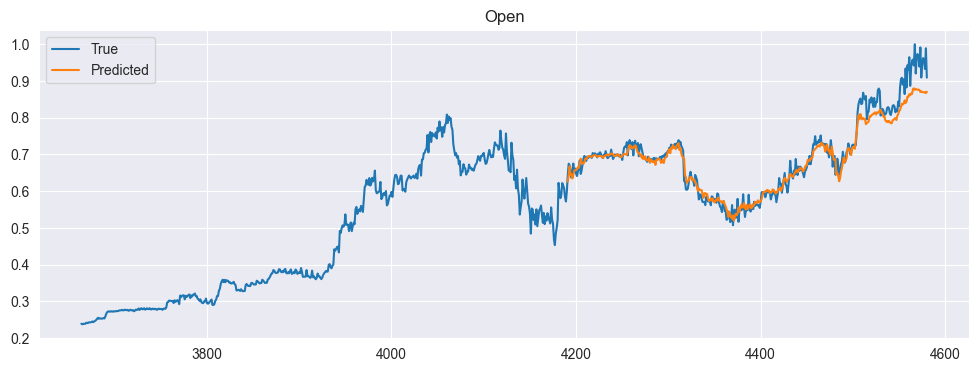

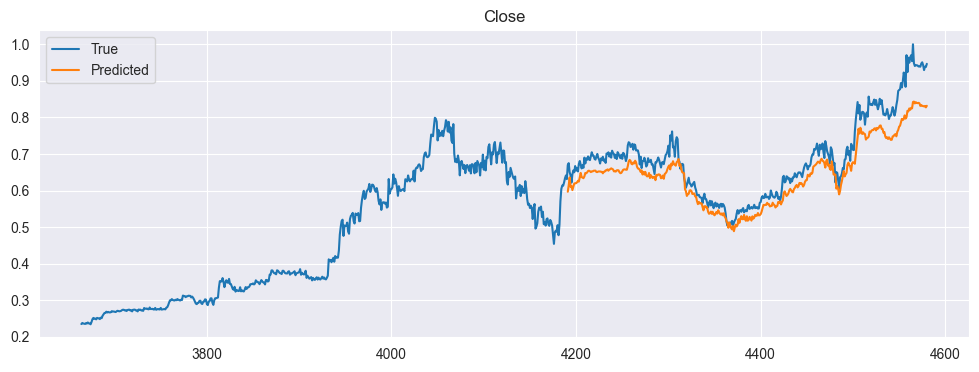

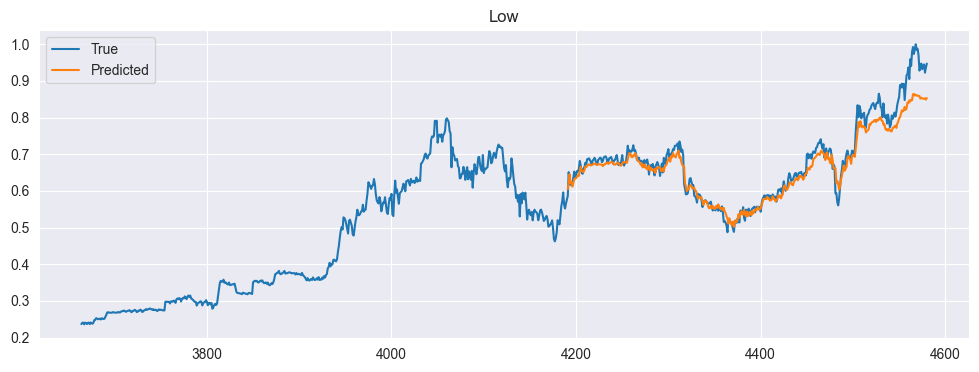

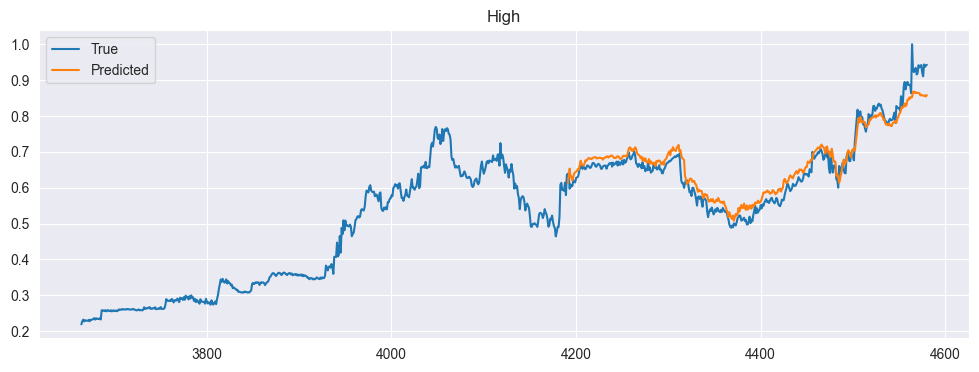

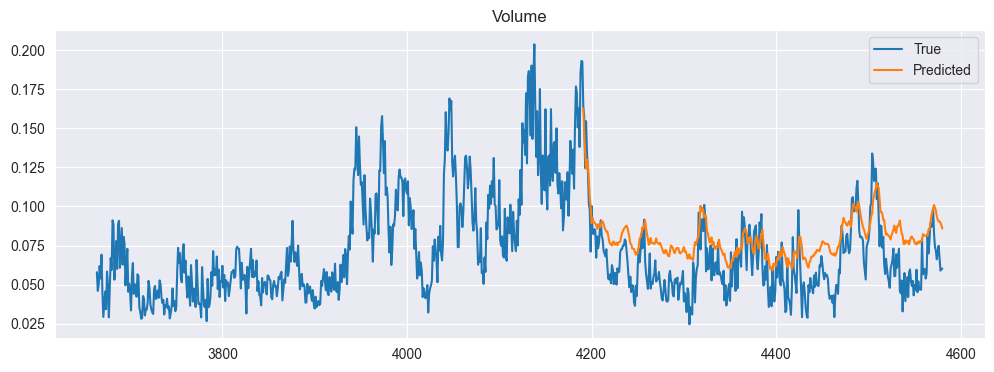

In [39]:
y_pred = model_stacked_rnn.predict(test_data_gen)  
start_index = int(len(nflx_stock) * 4 // 5)
total_length = nflx_stock.shape[0]
pred_padding_length = total_length - len(y_pred)
columns = ["Open", "Close", "Low", "High", "Volume"]
for i in range(len(columns)):
    y_true = nflx_stock[columns[i]].iloc[start_index:]
    plt.figure(figsize=(12, 4))
    plt.plot(y_true, label="True")
    plt.plot(range(pred_padding_length, total_length), y_pred[:, i], label="Predicted")
    plt.title(columns[i])
    plt.legend()
    plt.show()

### Comparison
Let's compare the results of all the models using metrics from sklearn, that are more readable and interpretable.

In [46]:
y_pred_lstm = pd.DataFrame(model_lstm.predict(test_data_gen), columns=["Open", "Close", "Low", "High", "Volume"])
y_pred_gru = pd.DataFrame(model_gru.predict(test_data_gen), columns=["Open", "Close", "Low", "High", "Volume"])
y_pred_rnn = pd.DataFrame(model_rnn.predict(test_data_gen), columns=["Open", "Close", "Low", "High", "Volume"])
y_pred_stacked_rnn = pd.DataFrame(model_stacked_rnn.predict(test_data_gen), columns=["Open", "Close", "Low", "High", "Volume"])

390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [77]:
results: dict[str, dict[str, dict]] = {}
y_true = test[look_back:].drop(columns=["Date"])
for model_name, y_pred in zip(["LSTM", "GRU", "RNN", "Stacked RNN"], [y_pred_lstm, y_pred_gru, y_pred_rnn, y_pred_stacked_rnn]):
    results[model_name] = {}
    for column in ["Open", "Close", "Low", "High", "Volume"]:
        results[model_name][column] = {
            "mse": mean_squared_error(y_true[column], y_pred[column]),
            "r2": r2_score(y_true[column], y_pred[column])
        }
    results[model_name]["combined"] = {
        "mse": mean_squared_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred)
    }
for model_name, item in results.items():
    print(model_name)
    for column, metrics in item.items():
        print(f"\t{column}:\n\t\tMSE: {metrics['mse']}\n\t\tR2: {metrics['r2']}")

LSTM
	Open:
		MSE: 0.0007034203569170961
		R2: 0.9381195549216268
	Close:
		MSE: 0.0021602224725842316
		R2: 0.8168855964979705
	Low:
		MSE: 0.0009152249353438347
		R2: 0.9246286313050023
	High:
		MSE: 0.000843121526998773
		R2: 0.9275938073637737
	Volume:
		MSE: 0.00025260463889498853
		R2: 0.4451602794743623
	combined:
		MSE: 0.0007102228690022987
		R2: 0.8329255284882221
GRU
	Open:
		MSE: 0.0006593138388948944
		R2: 0.9419996401924499
	Close:
		MSE: 0.0012223615132864456
		R2: 0.8963847463814596
	Low:
		MSE: 0.0007883450767765802
		R2: 0.9350775474465287
	High:
		MSE: 0.0015491811089614208
		R2: 0.8669583183302748
	Volume:
		MSE: 0.000253326090949579
		R2: 0.44357562822610075
	combined:
		MSE: 0.0006902701068253209
		R2: 0.8342496058669878
RNN
	Open:
		MSE: 0.000675614387438513
		R2: 0.9405656680462334
	Close:
		MSE: 0.0022618962600326428
		R2: 0.8082670698523627
	Low:
		MSE: 0.0008964435262129772
		R2: 0.9261753336046742
	High:
		MSE: 0.0010611554209655394
		R2: 0.9088693369022252


It appears Simple RNN has the best results when it comes to R2 and GRU has the best results when it comes to MSE. Therefore, we only tweak hyperparameters of these 2 models to save time.

## Optimization

In [17]:
logging.basicConfig(filename="training_log.log",
                    filemode='a',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)
os.environ["WANDB_SILENT"] = "true"
wandb.login()
wandb.init()
class WandbCallback(Callback):
    def __init__(self, config):
        super().__init__()
        self.config = config

    def on_epoch_end(self, epoch, logs=None):
        wandb.log(logs, step=epoch)

In [18]:
def hyperparameter_tune(train_data, test_data,  **hyperparams):
    lookback = hyperparams["look_back"]
    batch_size = hyperparams["batch_size"]
    train_tsgen = TimeseriesGenerator(train_data, 
                                      train_data,
                                      length=lookback, 
                                      sampling_rate=1,
                                      stride=1,
                                      batch_size=batch_size
                                     )
    
    test_tsgen = TimeseriesGenerator(test_data, 
                                     test_data,
                                     length=lookback, 
                                     sampling_rate=1,
                                     stride=1,
                                     batch_size=batch_size
                                    )
    
    x = Input(shape=(lookback, 5))
    if not "model" in hyperparams:
        hyperparams["model"] = "SimpleRNN"
    if hyperparams["model"] == "SimpleRNN":
        h = SimpleRNN(units=hyperparams["units"])(x)
    else:
        h = GRU(units=hyperparams["units"])(x)
    y = Dense(units=5, activation=hyperparams["activation"])(h)
    model = Model(inputs=x, outputs=y)
    opt = Adam(learning_rate=hyperparams["learning_rate"])
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mse', 'mae'])
    model.fit(train_tsgen, epochs=20, callbacks=[WandbCallback(hyperparams)], verbose=False)
    return model.evaluate(test_tsgen)

In [121]:
%%capture --no-stdout
config = {
    "units": [5, 10, 15],
    "batch_size": [4, 8, 16],
    "lookback": [10, 14, 18],
    "activation": ["sigmoid"],  # we are not going to use more, as the data is within 0-1 range and testing more would be not worth the resources
    "learning_rate": [0.005, 0.001, 0.0005]
}
n = 0
for unit in config["units"]:
    for batch_size in config["batch_size"]:
        for lookback in config["lookback"]:
            for activation in config["activation"]:
                for learning_rate in config["learning_rate"]:
                    results = hyperparameter_tune(dl_train.values, dl_test.values, units=unit, batch_size=batch_size, look_back=lookback, activation=activation, learning_rate=learning_rate)
                    logging.info(f"Paremeters: {unit}, {batch_size}, {lookback}, {activation}, {learning_rate}")
                    logging.info(f"Results - (loss, mse, mae): {results}")

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0032 - mae: 0.0520 - mse: 0.0032
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0012 - mae: 0.0265 - mse: 0.0012
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0026 - mae: 0.0395 - mse: 0.0026
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - mae: 0.0295 - mse: 0.0014
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3944e-04 - mae: 0.0215 - mse: 9.3944e-04
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0487e-04 - mae: 0.0215 - mse: 9.0487e-04
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4896e-04 - mae: 0.0194 - mse: 5.4896e-04
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - mae: 0.0358 - mse: 0.0018
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0015 - mae: 0.0304 - mse: 0.0015
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3404e-04 - mae: 0.0238 - mse: 9.3404e-04
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0017 - mae: 0.0342 - mse: 0.0017
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041 - mae: 0.049

#### From the results (training_log.log), we can see that the best results tend to have lower batch sizes and higher lookback. We will do one final sweep, based on the findings.

In [ ]:
%%capture --no-stdout
# we will store the logs in a different file
logging.basicConfig(filename="training_log2.log",
                    filemode='a',
                    format='%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)

config = {
    "units": [5, 10, 15], 
    "batch_size": [1, 2, 4],
    "lookback": [16, 24, 32],
    "activation": ["sigmoid"],  # we are not going to use more, as the data is within 0-1 range and testing more would be not worth the resources
    "learning_rate": [0.005, 0.001, 0.0005]
}
n = 0
for model in ["SimpleRNN", "GRU"]: 
    for unit in config["units"]:
        for batch_size in config["batch_size"]:
            for lookback in config["lookback"]:
                for activation in config["activation"]:
                    for learning_rate in config["learning_rate"]:
                        results = hyperparameter_tune(dl_train.values, dl_test.values, units=unit, batch_size=batch_size, look_back=lookback, activation=activation, learning_rate=learning_rate, model=model)
                        logging.info(f"Paremeters: {unit}, {batch_size}, {lookback}, {activation}, {learning_rate}, {model}")
                        logging.info(f"Results - (loss, mse, mae): {results}")
                        n+=1
                        print(f"{n}",end=",")
                        

384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.1735e-04 - mae: 0.0156 - mse: 4.1735e-04
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.1544e-04 - mae: 0.0142 - mse: 3.1544e-04
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.0137e-04 - mae: 0.0127 - mse: 3.0137e-04
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.3785e-04 - mae: 0.0161 - mse: 4.3785e-04
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.6425e-04 - mae: 0.0198 - mse: 5.6425e-04
5,

# 4-1B & 4-2B Our Reasoning and Conclusion

### Data Preprocessing
We used STL decomposition to remove noise from the data. We kept the trend, but also seasonal as stock price is a thing that changes seasonally. We also scaled the data using MinMaxScaler, as the volume was in a completely different range compared to the other columns. We saw that prices were growing with time. The volume didn't seem to have a clear trend when we inspected it, and the testing confirmed it, as it had the lowest R2 score out of the columns.  
We also dropped the Adj Close column, as it was the same as the Close column. Therefore, if we want to predict Adj Close, we can just read what was predicted for Close.

### Model Choice
We chose the Linear Regression as the best model as it had the highest R2 score and the lowest MSE.  
We can be confident in our model choice, as we tested 324+2 different hyperparameter combinations for SimpleRNN and GRU hidden layer and 2 other deep learning models. We also tested 100 hyperparameters for predicting each column for Random Forest Regressor, which also didn't yield better results.